# Exploratory Notebook for bits & bobs

In [17]:
# Standard imports

import numpy as np
import pandas as pd
import json
import os
import tensorflow as tf
from matplotlib.collections import LineCollection


import matplotlib.pyplot as plt
import seaborn as sns


## Intersection over Union

In [ ]:
def return_IoU(box1, box2):

    """Function to generate the IoU for two bounding boxes in COCO format

    box1: list of floats representing bounding box (COCO format)
    box2: list of floats representing bounding box (COCO format)
    """

    # Convert from COCO format to corner format, this makes it simpler to calculate IoU
    box1 = [box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]]
    box2 = [box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3]]

    # Calculate intersection coordinates
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is no overlap
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


In [ ]:
# Get data path

currend_wd = os.getcwd()
target_file = "annotations.json"

raw_data_path = os.path.join(currend_wd, '..', 'raw_data')

# Load json file

with open(os.path.join(raw_data_path, target_file), 'r') as file:
    data = json.load(file)


In [ ]:
data.keys()


In [ ]:
subset_annotations = data['annotations'][:5]
test_bbox_0 = subset_annotations[0]['bbox']
test_bbox_1 = subset_annotations[1]['bbox']
test_bbox_2 = subset_annotations[2]['bbox']


test_bbox_0, test_bbox_1


In [ ]:
display(return_IoU(test_bbox_0, test_bbox_1))
# display(return_IoU(test_bbox_0, test_bbox_2))
# display(return_IoU(test_bbox_1, test_bbox_2))


In [ ]:
data['annotations'][0].keys()


In [ ]:
keys_to_keep = ['image_id', 'category_id', 'id', 'bbox', 'pose_cateogory'
                , 'pose_variation', 'exercise_category', 'intersection_over_union']

annotations_cleaned = [
    {key: value for key, value in annotation.items() if key in keys_to_keep}
    for annotation in data['annotations']
]

# Specify your filename
target_save_file = 'annotations_cleaned.json'

# Writing to a file in the same directory
with open(os.path.join(raw_data_path,target_save_file), 'w') as file:
    json.dump(annotations_cleaned, file)


In [ ]:
annotations_cleaned[100]


In [ ]:
annotations_cleaned_duplicate = annotations_cleaned.copy()

base_id = 1

for i in annotations_cleaned:

    img_id = i['image_id']

    i['iou'] = []
    i['iou_cat'] = False

    for j in annotations_cleaned_duplicate:

        if (img_id == j['image_id']):

            iou = return_IoU(i['bbox'], j['bbox'])

            if iou == 1.0:

                iou = 0.0

            i['iou'].append(iou)

            print(f"Image {img_id}: comparing {i['id']} and {j['id']}")
            print(f"IOU = {iou}")

            if iou > 0.1:

                i['iou_cat'] = True

        if img_id < j['image_id']:

            break

    if img_id > base_id:

        for k in annotations_cleaned_duplicate:

            if k['image_id'] == base_id:

                annotations_cleaned_duplicate.remove(k)

            else:

                break



    # base_id = img_id

    # for k in annotations_cleaned_duplicate:

    #     if k['image_id'] == img_id:

    #         annotations_cleaned_duplicate.remove(k)

    #     else:

    #         break


In [ ]:
len(annotations_cleaned)


In [ ]:
overlap_annotations = [annotation for annotation in annotations_cleaned if annotation['iou_cat'] == True]

len(overlap_annotations)


In [ ]:
# Specify your filename
target_save_file = 'annotations_cleaned_IoU.json'

# Writing to a file in the same directory
with open(os.path.join(raw_data_path,target_save_file), 'w') as file:
    json.dump(annotations_cleaned, file)


## Cropping images code

In [ ]:
def crop_image(file_name, bbox, index, iou, pose_variation):
    image = plt.imread(f'../raw_data/00/{file_name}')
    x0 = int(bbox[0])
    y0 = int(bbox[1])
    width = int(bbox[2])
    height = int(bbox[3])
    wanted_boundaries_array = image[y0:y0+height , x0:x0+width, :]
    # fig = plt.figure()
    # ax = fig.add_subplot(121)
    im_crop = plt.imshow(image[y0:y0+height , x0:x0+width, :])
    plt.axis('off')
    plt.tight_layout()
    #copied_im = im_crop.copy()
    plt.savefig(f'../raw_data/00_cropped/{file_name}_{index}_{iou}_{pose_variation}_cropped.png'
                ,bbox_inches='tight'
                , pad_inches=0)

    return str(file_name) + "_" + str(index) + "_cropped"


In [ ]:
crop_image('00000001.rgb.png', [0, 0, 100, 100], 1, 0.5, 'variation')


In [ ]:
raw_data_folders = os.listdir('../raw_data/unprocessed_data/')
raw_data_folders.remove('.DS_Store')
raw_data_folders.sort()
raw_data_folders


In [ ]:
import numpy as np

def cmyk_to_rgb_modified(cmyk_tensor, max_value=255):
    # Normalize the tensor to the range [0, 1]
    cmyk_normalized = cmyk_tensor / max_value

    # Extract the CMYK channels
    C, M, Y, K = np.split(cmyk_normalized, 4, axis=-1)

    # Scale the K channel's influence
    K_scale = 1 - K**0.5  # Exponential scaling to reduce the influence of high K values

    # Convert CMYK to CMY with modified K influence
    C = C * K_scale
    M = M * K_scale
    Y = Y * K_scale

    # Convert CMY to RGB
    R = 1 - C
    G = 1 - M
    B = 1 - Y

    # Concatenate back into a single tensor
    rgb_tensor = np.concatenate([R, G, B], axis=-1)

    return rgb_tensor


In [ ]:
test_tensor_uncropped = tf.io.read_file("../raw_data/unprocessed_data/00000020.rgb.png")

# test_tensor_cropped = tf.io.read_file("../raw_data/cropped_data/squats/00000019.rgb.png_squats_0.09_cropped.png")

test_tensor_png = tf.io.decode_png(test_tensor_uncropped)

plt.imshow(test_tensor_png[:,:,:3])


In [ ]:
"00000011.rgb.png".removesuffix(".rgb.png")


## MOVENET

In [7]:
import tensorflow_hub as hub


In [53]:
model = hub.load("https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/singlepose-lightning/versions/4")
movenet = model.signatures['serving_default']


In [60]:
model


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x3dbbd9600>

In [44]:
model.signatures.keys()


KeysView(_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input) at 0x31746B460>}))

In [9]:
image_path = "/Users/mischadhar/code/ds-projects/pose-detection/q4-repo/pt-ai/raw_data/cropped_data/lunge_right/00000215_lunge_right_0.042_cropped.png"
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_png(image)
image = image[:,:,:3]
image = tf.expand_dims(image, axis=0)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.cast(tf.image.resize_with_pad(image, 192, 192), dtype=tf.int32)


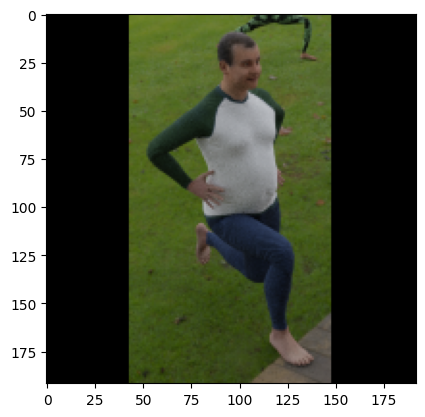

In [10]:
plt.imshow(image[0])


In [11]:
# Run model inference.
outputs = movenet(image)
# Output is a [1, 1, 17, 3] tensor.
keypoints_with_scores = outputs['output_0'].numpy()

keypoints_with_scores


2023-12-03 15:49:40.834251: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[[0.15664577, 0.5660628 , 0.7285435 ],
         [0.13543412, 0.5693712 , 0.8298082 ],
         [0.13740462, 0.53867835, 0.6580174 ],
         [0.1373262 , 0.5507822 , 0.6440953 ],
         [0.14988044, 0.47957844, 0.6127131 ],
         [0.23321597, 0.5954194 , 0.8388471 ],
         [0.26124266, 0.42660555, 0.90225995],
         [0.31560645, 0.59620315, 0.37669536],
         [0.36987954, 0.29622054, 0.87592787],
         [0.3850877 , 0.6211369 , 0.32372504],
         [0.46350354, 0.39987406, 0.48826814],
         [0.52156913, 0.59565085, 0.8586626 ],
         [0.5418504 , 0.4827027 , 0.9119474 ],
         [0.6974003 , 0.5885776 , 0.4238746 ],
         [0.65734833, 0.6441845 , 0.6335117 ],
         [0.6201412 , 0.43760157, 0.78975034],
         [0.86896455, 0.6351832 , 0.63109756]]]], dtype=float32)

In [12]:
image_path = '/Users/mischadhar/code/ds-projects/pose-detection/q4-repo/pt-ai/raw_data/cropped_data/lunge_right/00000215_lunge_right_0.042_cropped.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image)[:,:,:3]
image


<tf.Tensor: shape=(327, 179, 3), dtype=uint8, numpy=
array([[[105, 129,  36],
        [106, 129,  35],
        [107, 129,  34],
        ...,
        [103, 123,  49],
        [104, 124,  51],
        [101, 122,  49]],

       [[102, 127,  35],
        [103, 127,  34],
        [105, 128,  35],
        ...,
        [100, 123,  48],
        [101, 123,  49],
        [ 99, 122,  48]],

       [[100, 125,  35],
        [102, 126,  37],
        [104, 127,  37],
        ...,
        [ 96, 120,  46],
        [ 96, 120,  45],
        [ 95, 119,  44]],

       ...,

       [[ 52,  72,   8],
        [ 55,  72,  10],
        [ 60,  73,  16],
        ...,
        [ 89,  81,  77],
        [ 90,  82,  77],
        [ 91,  84,  79]],

       [[ 55,  73,  12],
        [ 54,  71,  10],
        [ 49,  62,  12],
        ...,
        [ 90,  83,  79],
        [ 92,  85,  80],
        [ 90,  83,  79]],

       [[ 57,  73,  17],
        [ 54,  69,  16],
        [ 45,  56,  14],
        ...,
        [ 89,  82,  7

(1200, 1200, 3)


/var/folders/wv/5z59yrjd3m95jny5q2nx1sd40000gn/T/ipykernel_1689/2988513080.py:163: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


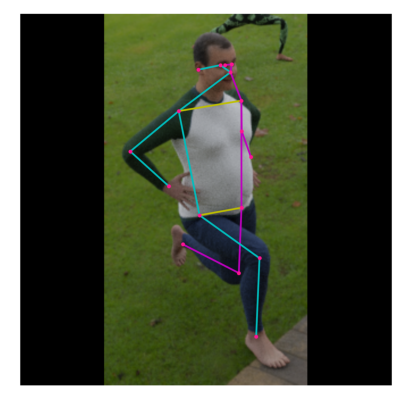

In [13]:
# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')


In [14]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape

  aspect_ratio = float(width) / height

  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)

  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))

  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))


## Loading the MoveNet model from local path

In [19]:
saved_model_path  = "/Users/mischadhar/code/ds-projects/pose-detection/q4-repo/pt-ai/raw_data/models/movenet"


In [66]:
model_tfhub = tf.saved_model.load(saved_model_path)


In [67]:
model_tfhub.signatures


_SignatureMap({})